In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import spatial_transformations as tr
import scipy
plt.rcParams['image.cmap'] = 'gray'

# Spatial transformations for augmentations in deep learning

This package enables you to make fast spatial transformations for the purpose of data augmentation in deep learning. The supported spatial transformations are
* Translations
* Rigid transformations (translation + rotation)
* Similarity transformations (translation + rotation + isotropic scaling)
* Affine transformations (translation + rotation + arbitrary scaling + shearing)
* Deformable transformations (modeled as B-splines)

The tutorial below shows most functionality of this package. A small minimal working example is shown at the [end](#mwe).

To get started, we load the example image, and fashion it with some grid lines to show what each of the transformations do. The tutorial is using a 2D image, but in principle all code should generalize to arbitrary dimensions 

In [2]:
image = plt.imread('lung_ct.png')
image = image[:, :, 0] # The image was loaded as RGB color image, but we only need one channel.
image[10::20] = 1
image[11::20] = 1
image[:, 10::20] = 1
image[:, 11::20] = 1

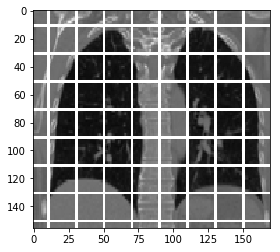

In [18]:
plt.imshow(image);https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.interpolation.map_coordinates.html

## Transformations and interpolations, an example using translations

Spatial image transformations move the *sampling grid* of an image. This means that the effect of a transformation has the opposite effect on the image itself. For example, a translation to the *right* means that the *grid* is translated to the right, which means that the objects in you image move to the *left*. You can compare this to a camera: if you move the camera to the right, the objects on the picture will move to the left.

Let's make a translation transform that moves the image by 10% to the left:

In [4]:
my_translation = tr.TranslationTransform([0, 0.1])

As you can see, the translation is defined in terms of *image indices* $i, j$, and not in terms of coordinates $x,y$. A translation of 10% to the left means that we have to move the sampling grid 10% to the right, which means we have to move the $j$-axis of the grid.

We can move points to check this. Here we move the point $(0.5, 0.5)$ which is the center of the grid:

In [5]:
my_translation.transform([[0.5], [0.5]])

array([[0.5],
       [0.6]])

As you can see, the $j$-component has been shifted 10% to the right. When we apply the transformation to the image it can happen that the transformed grid points fall in between the points on the original grid. That is why we need to use an interpolator for this image. By default, we use a third-order B-spline interpolator.

*This is different from the B-spline we use to *deform* images later on!*

In [6]:
my_image_interpolator = tr.Interpolator(image)

We can transform the interpolator, to show the result:

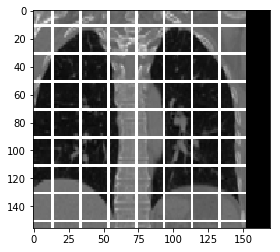

In [17]:
my_translated_image = my_image_interpolator.transform(my_translation)
plt.imshow(my_translated_image);

As you can see, the image has been shifted 10% to the left!

## More advanced linear transformations

In a linear transformation, the transformation of points can be expressed as $\mathbf{x}_{new} = A \mathbf{x}_{old} + \mathbf{b}$, where $A$ is a matrix and $\mathbf{b}$ is a translation vector. Again note that the transformation has the opposite effect on the image itself.

We define linear transformations in a matrix $[A, \mathbf{b}]$, for example, a 45° rotation can be defined as

In [8]:
angle = np.pi / 4.
my_rotation_matrix = [
    [np.cos(angle), -np.sin(angle), 0],
    [np.sin(angle), np.cos(angle), 0]
]

The transformation can be defined as

In [9]:
my_rotation = tr.LinearTransform(my_rotation_matrix)

that we can now apply to the image:

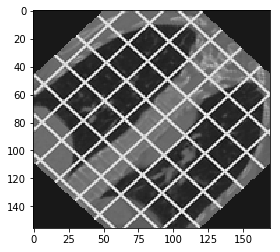

In [16]:
my_rotated_image = my_image_interpolator.transform(my_rotation)
plt.imshow(my_rotated_image);

Note that the center of rotation is the upper left corner (the $(0, 0)$ coordinate). We can change that by using the utility function `affine_matrix` that creates new linear matrices based on more meaningful parameters:

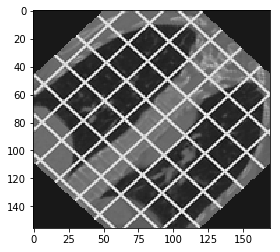

In [15]:
my_rotation_matrix = tr.affine_matrix(
    angles=[np.pi/4.], # List of angles (for 3D transformations you need a list of 3 angles).
    center=[0.5, 0.5]  # Center of rotation.
)
my_rotation = tr.LinearTransform(my_rotation_matrix)
my_rotated_image = my_image_interpolator.transform(my_rotation)
plt.imshow(my_rotated_image);

Notice that the image shows a clockwise rotation of the objects in the image, but that the definition of the transformation was counter clockwise. Again, this is because a counter clockwise rotation of the sampling grid results in a clockwise rotation of the objects in the image.

We can make more complicated transformations too, using more parameters, resulting in affine transformations.

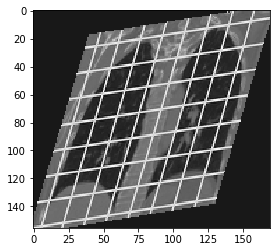

In [14]:
my_affine_matrix = tr.affine_matrix(
    angles=[np.pi/10.], # the rotation angle
    scaling=[1.2, 1.2], # the anisotropic scaling
    shear_matrix=[[1, 0.5], [0, 1]], # shearing matrix
    translation=[0, 0], # translation
    center=[0.5, 0.5] # center of rotation
)
my_affine_transformation = tr.LinearTransform(my_affine_matrix)
my_affine_image = my_image_interpolator.transform(my_affine_transformation)
plt.imshow(my_affine_image);

## Deformable transformations


Fully deformable transformations are great for biomedical applications, because it can transform biological tissue in a more or less realistic way.

Deformable transformations are implemented as B-spline transformations. They are defined as *displacements* on a grid. For two-dimensional images we implement two grids, one for the displacements in the $i$-directions, and one for the displacements in the $j$-directions, so for example, for a 3x3 grid:

In [13]:
disp_i = np.array([
    [0.05, 0.02, 0.04],
    [-0.04, 0.01, -0.02],
    [-0.04, -0.01, -0.01]
])
disp_j = np.array([
    [0.04, -0.03, -0.05],
    [0.02, 0.03, 0.05],
    [0.02, -0.04, -0.05]
])

We then create a B-spline transformation

In [21]:
my_bspline_transformation = tr.BSplineTransform([disp_i, disp_j])

and apply it to the image:

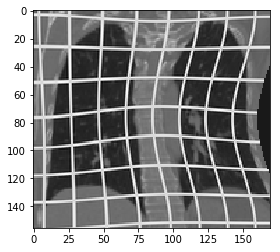

In [22]:
my_deformed_image = my_image_interpolator.transform(my_bspline_transformation)
plt.imshow(my_deformed_image);

Beware of folding and tearing of the image. If you make the displacements too large, or the grid too fine, you will end up with unrealistic deformations, from which your network will likely be unable to learn anything useful.

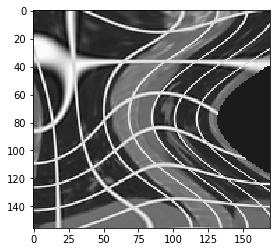

In [19]:
my_folding_bspline_transformation = tr.BSplineTransform([5*disp_i, 5*disp_j])
my_terribly_deformed_image = my_image_interpolator.transform(my_folding_bspline_transformation)
plt.imshow(my_terribly_deformed_image);

### Checking for folding using the Jacobian
You can inspect the folding by computing the Jacobian determinant on a `Grid` object. Wherever the Jacobian determinant is below zero, the image has folded, and information has disappeared.

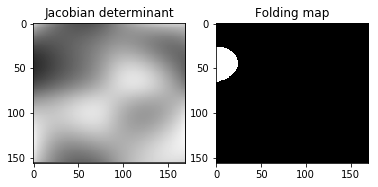

In [31]:
my_grid = tr.Grid(image.shape)
jac_det = my_grid.jacobian_det(my_folding_bspline_transformation)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(jac_det, vmin=-2e-5, vmax=5e-5);
ax[1].imshow(jac_det < 0);
ax[0].set_title('Jacobian determinant');
ax[1].set_title('Folding map');

For the well-behaved B-spline transformation we had before, the Jacobian does not show folding:

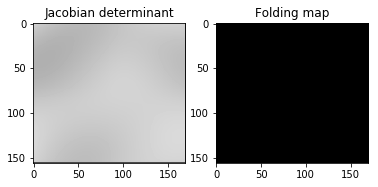

In [30]:
my_grid = tr.Grid(image.shape)
jac_det = my_grid.jacobian_det(my_bspline_transformation)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(jac_det, vmin=-2e-5, vmax=5e-5);
ax[1].imshow(jac_det < 0);
ax[0].set_title('Jacobian determinant');
ax[1].set_title('Folding map');

### Plotting the displacement field
The displacement field can be plotted using a Grid object. The displacement field is the difference between the transformed grid and the original grid.

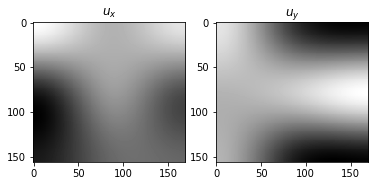

In [29]:
my_grid = tr.Grid(image.shape)
transformed_grid = my_grid.transform(my_folding_bspline_transformation)
displacement_field = transformed_grid.grid - my_grid.grid

fig, ax = plt.subplots(1, 2)
ax[0].imshow(displacement_field[0]);
ax[1].imshow(displacement_field[1]);
ax[0].set_title('$u_x$');
ax[1].set_title('$u_y$');

## Combining transformations

You can concatenate transformations (for example affine and a B-spline transformations) by simply putting a list of transformations to the `transform()` method of a interpolator. Note that the transformations are applied in reverse order. Again, this is because the transformations are applied to the sampling grid rather than the images. The example below first applies the 10% translation from above *first*, *then* the 45° rotation around the (0.5, 0.5) in the resulting image (!), and *then* the B-spline transformation. Even though multiple transformations are applied, the are all applied to the grid first before any interpolation in the image is performed.

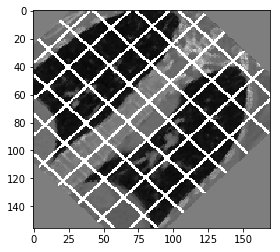

In [27]:
composed = tr.ComposedTransform(my_rotation, my_translation)
twice_transformed_image = my_image_interpolator.transform(composed)
plt.imshow(twice_transformed_image);

# Interpolation options
The Interpolation object has parameters for which order of B-spline should be used, as well as how the interpolator should extrapolate. The options are
* `order`: The order of the B-spline.
* `mode`: Any of ‘constant’, ‘nearest’, ‘reflect’ or ‘wrap’.
* `cval`: The background value for `mode='constant'`

### Different background intensity

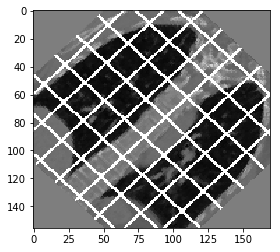

In [26]:
my_image_interpolator = tr.Interpolator(image, order=0, cval=0.5)
tr_image = my_image_interpolator.transform(my_rotation)
plt.imshow(tr_image);

### Border-modes

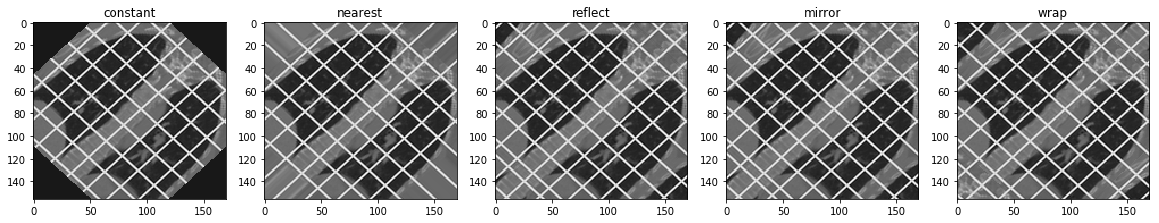

In [23]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5));
for i, mode in enumerate(['constant', 'nearest', 'reflect', 'mirror', 'wrap']):
    my_image_interpolator = tr.Interpolator(image, mode=mode)
    tr_image = my_image_interpolator.transform(my_rotation)
    ax[i].imshow(tr_image);
    ax[i].set_title(mode);

### B-spline orders

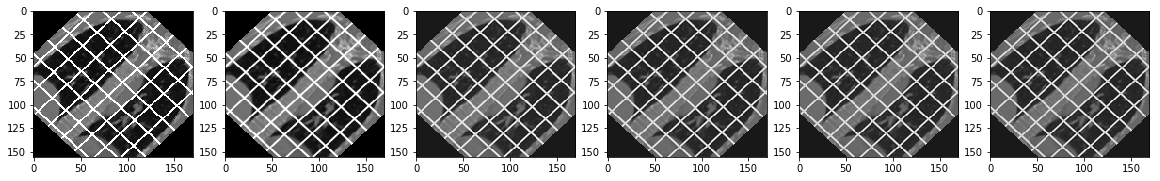

In [24]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5));
for i in range(6):
    my_image_interpolator = tr.Interpolator(image, order=i)
    tr_image = my_image_interpolator.transform(my_rotation)
    ax[i].imshow(tr_image);

<a name="mwe"></a>
# A minimal working example for data augmentation

You can use the numpy.random module to make random transformations. During training of your network you can implement something like the code below:

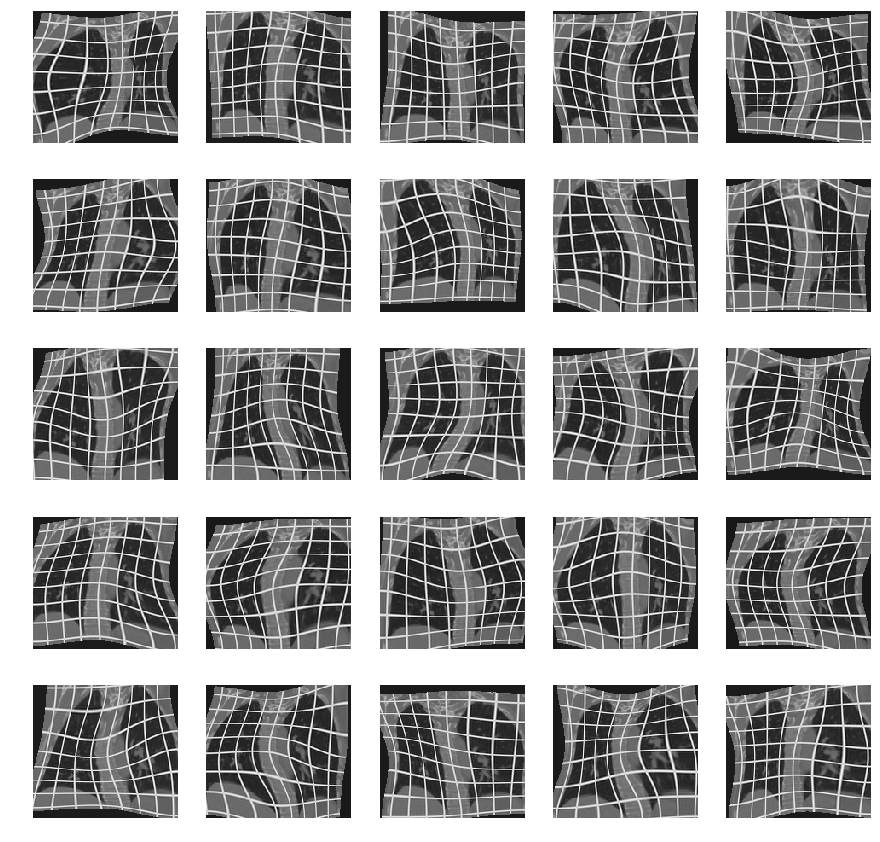

In [25]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15));
ax = ax.flatten()
[x.set_axis_off() for x in ax];

for i in range(25):
    random_grid = np.random.rand(2, 3, 3) # Make a random 2D 3 x 3 grid
    random_grid -= 0.5 # Move the displacements to the -0.5 to 0.5 grid
    random_grid /= 5 # Scale the grid to -0.1 to 0.1 displacements

    my_augmentation = tr.BSplineTransform(random_grid)
    my_augmented_image = my_image_interpolator.transform(my_augmentation)
    
    ax[i].imshow(my_augmented_image);